In [1]:
import pandas as pd

In [2]:
congress = pd.read_csv('Raw Data-selected/capitoltrades.com raw data - Sheet1.csv')
congress.shape

(2304, 9)

In [3]:
insiders = pd.read_csv('Raw Data-selected/insider_trades_2020_2025.csv')
insiders.shape

(71712, 12)

In [4]:
insiders = insiders[insiders['ticker'].notna()]
insiders = insiders[insiders['transaction_type'] == 'P - Purchase']
insiders = insiders[insiders['Qty'] != '+0']
insiders.shape

(71481, 12)

In [5]:
prices = pd.read_csv('Raw Data-selected/stock_price_data.csv')
prices.shape

(1457, 8363)

In [6]:
len(insiders['ticker'].unique())

5687

In [7]:
congress['Ticker'] = [i.split('\n')[1].replace(':US','') for i in congress['Traded Issuer'].tolist()]
congress.shape

(2304, 10)

In [8]:
congress = congress[congress['Price'].notna()]
congress.shape

(2292, 10)

In [9]:
len(congress['Ticker'].unique())

454

In [10]:
from datetime import datetime

In [11]:
lista = []
for date_string in congress['Published'].tolist():
    if 'Sept' in date_string:
        date_string = date_string.replace('t','')
    lista.append(datetime.strptime(date_string, "%d %b\n%Y"))
congress['Published'] = lista
lista = []
for date_string in congress['Traded'].tolist():
    if 'Sept' in date_string:
        date_string = date_string.replace('t','')
    lista.append(datetime.strptime(date_string, "%d %b\n%Y"))
congress['Traded'] = lista
congress.shape

(2292, 10)

In [12]:
lista = []
for date_string in insiders['trade_date'].tolist():
    date_string = date_string.split(' ')[0]
    lista.append(datetime.strptime(date_string, "%Y-%m-%d"))
insiders['trade_date'] = lista

In [13]:
prices['Date'] = [datetime.strptime(date_string, "%Y-%m-%d") for date_string in prices['Date'].tolist()]
prices.shape

(1457, 8363)

In [14]:
insiders['trade_date'].min()

Timestamp('2020-01-02 00:00:00')

In [15]:
insiders = insiders[insiders['trade_date'] >= congress['Traded'].min()]
insiders.shape

(33543, 12)

In [16]:
prices = prices[prices['Date'] >= congress['Traded'].min()]
prices.shape

(753, 8363)

In [17]:
tickers = list(set(congress['Ticker'].tolist() + insiders['ticker'].tolist()))
len(tickers)

4065

In [18]:
price_tickers = []
for i in prices.columns:
    if '_close' in i and i.split('_')[0] in tickers:
        price_tickers.append(i.split('_')[0])
len(price_tickers)

3501

In [19]:
union = set(tickers) & set(price_tickers)
union = list(union)
len(union)

3501

In [20]:
insiders = insiders[insiders['ticker'].isin(union)]
congress = congress[congress['Ticker'].isin(union)]
insiders.shape, congress.shape

((30585, 12), (2237, 10))

In [21]:
insiders = insiders.sort_values('trade_date')
prices = prices.sort_values('Date')
congress = congress.sort_values('Traded')
insiders.shape, prices.shape, congress.shape

((30585, 12), (753, 8363), (2237, 10))

In [22]:
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import numpy as np

In [100]:
congressional_trades = congress.groupby(['Politician','Traded','Ticker']).agg(list)
month1 = []
month2 = []
month3 = []
month6 = []
year1 = []
year2 = []
for index, row in tqdm(congressional_trades.iterrows()):
    date = index[1]
    ticker = index[2]
    ps = np.mean([float(i.replace('$','').replace(',','')) for i in row['Price']])
    filt = prices[prices['Date'] >= date + relativedelta(months=1)]
    if len(filt) == 0:
        continue
    p = filt.iloc[0][f'{ticker}_close']
    month1.append((p, ps))
    filt = prices[prices['Date'] >= date + relativedelta(months=2)]
    if len(filt) == 0:
        continue
    p = filt.iloc[0][f'{ticker}_close']
    month2.append((p, ps))
    filt = prices[prices['Date'] >= date + relativedelta(months=3)]
    if len(filt) == 0:
        continue
    p = filt.iloc[0][f'{ticker}_close']
    month3.append((p, ps))
    filt = prices[prices['Date'] >= date + relativedelta(months=6)]
    if len(filt) == 0:
        continue
    p = filt.iloc[0][f'{ticker}_close']
    month6.append((p, ps))
    filt = prices[prices['Date'] >= date + relativedelta(years=1)]
    if len(filt) == 0:
        continue
    p = filt.iloc[0][f'{ticker}_close']
    year1.append((p, ps))
    filt = prices[prices['Date'] >= date + relativedelta(years=2)]
    if len(filt) == 0:
        continue
    p = filt.iloc[0][f'{ticker}_close']
    year2.append((p, ps))

1862it [02:14, 13.89it/s]


In [101]:
import matplotlib.pyplot as plt
def plotProfit(lista, time, name=None):
    list1 = [i[0] for i in lista]
    list2 = [i[1] for i in lista]
    plt.scatter(list2, list1)
    plt.xlabel('Bought Price')
    plt.ylabel(f'Price after {time}')
    if name is not None:
        plt.savefig(f'{name}.pdf',format='pdf');

In [91]:
def plotProfitHist(lista, time, size=2, name=None):
    list1 = [100 * (i[0]/i[1] - 1) for i in lista]
    print(pd.Series(list1).describe())
    plt.hist(list1, bins=np.arange(-100, 100, size))
    plt.xlabel('Profit Percentage')
    plt.title(f'{time} Profit Percentages')
    if name is not None:
        plt.savefig(f'{name}.pdf',format='pdf');

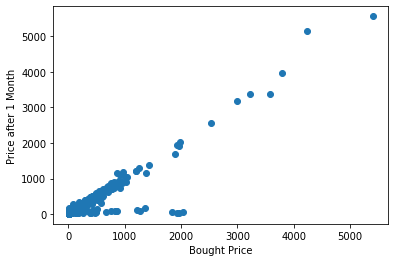

In [107]:
plotProfit(month1, '1 Month', name='1monthcongressscatter')

count    1846.000000
mean        0.188017
std        54.836135
min       -98.144187
25%        -7.491994
50%        -1.186776
75%         5.239442
max      1827.272695
dtype: float64


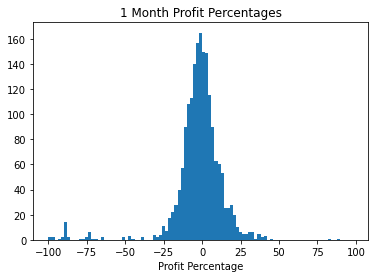

In [108]:
plotProfitHist(month1, '1 Month',name='1monthcongresshist')

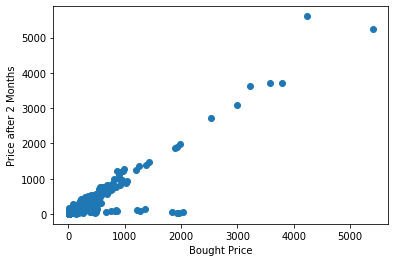

In [109]:
plotProfit(month2, '2 Months', name='2monthcongressscatter')

count    1806.000000
mean        2.287529
std        52.978647
min       -98.096979
25%        -8.237226
50%         0.181995
75%         9.548677
max      1683.957252
dtype: float64


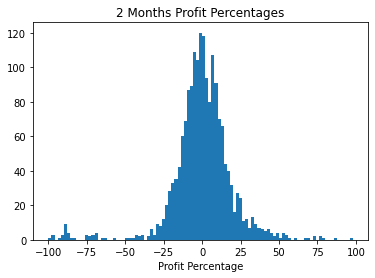

In [110]:
plotProfitHist(month2, '2 Months',name='2monthcongresshist')

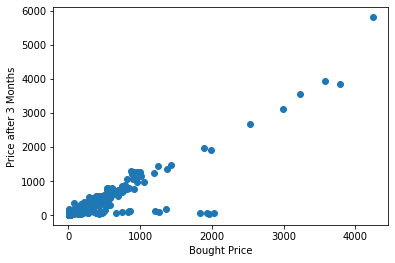

In [111]:
plotProfit(month3, '3 Months',name='3monthcongressscatter')

count    1729.000000
mean        4.284830
std        55.897995
min       -98.053998
25%        -8.259099
50%         2.098657
75%        12.724313
max      1829.411699
dtype: float64


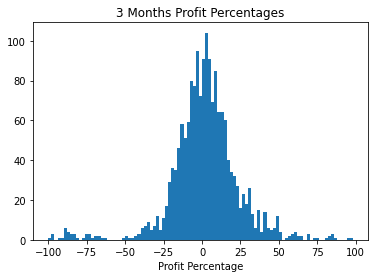

In [112]:
plotProfitHist(month3, '3 Months',name='3monthcongressscatter')

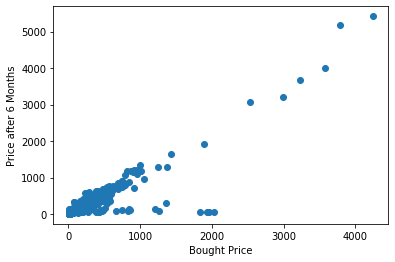

In [113]:
plotProfit(month6, '6 Months',name='6monthcongressscatter')

count    1571.000000
mean        8.838750
std        48.936217
min       -97.534215
25%        -8.784388
50%         5.782310
75%        20.553798
max      1098.682404
dtype: float64


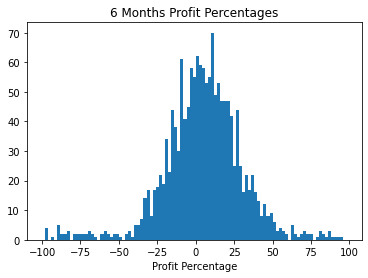

In [114]:
plotProfitHist(month6, '6 Months',name='6monthcongresshist')

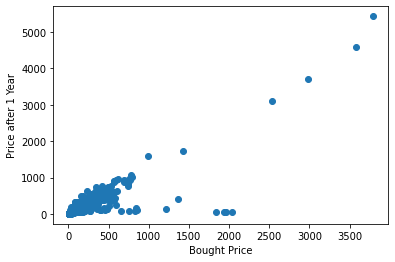

In [115]:
plotProfit(year1, '1 Year',name='1yearcongressscatter')

count    1121.000000
mean       12.099571
std        44.631348
min       -97.320974
25%       -10.952443
50%         8.964034
75%        30.150506
max       494.741920
dtype: float64


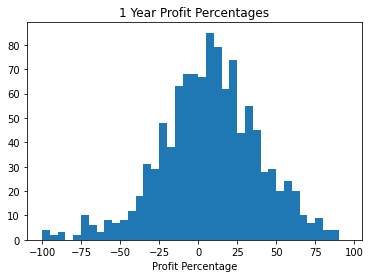

In [116]:
plotProfitHist(year1, '1 Year', size=5,name='1yearcongresshist')

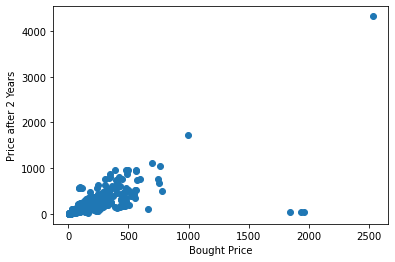

In [117]:
plotProfit(year2, '2 Years',name='2yearcongressscatter')

count    632.000000
mean      24.447951
std       61.013471
min      -98.001593
25%      -10.861674
50%       18.366562
75%       49.222620
max      528.638494
dtype: float64


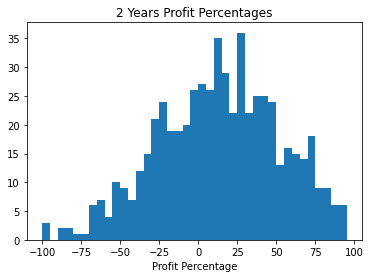

In [118]:
plotProfitHist(year2, '2 Years', size=5,name='2yearcongresshist')

In [38]:
import math
def transform(lista):
    lista = [100 * (i[0]/i[1] - 1) for i in lista]
    return [i for i in lista if not math.isnan(i)]

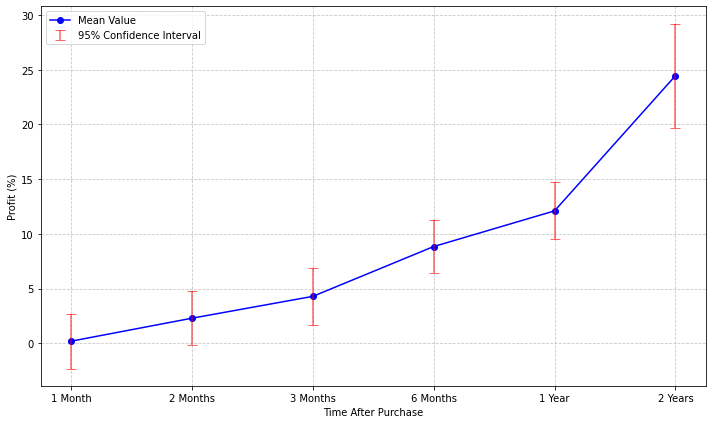

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --- 1. SAMPLE DATA ---
# This simulates your list of lists (e.g., performance across different experiment settings)
# Example: 4 experimental conditions, each with 20 runs (N=20)
data_lists = [
    month1,
    month2,
    month3,
    month6,
    year1,
    year2
]
data_lists = [transform(i) for i in data_lists]
labels = ['1 Month', '2 Months', '3 Months', '6 Months', '1 Year', '2 Years']

# --- 2. CALCULATE MEAN AND 95% CONFIDENCE INTERVALS (CI) ---

means = []
ci_lower = []
ci_upper = []
ci_margins = [] # The distance from the mean (Margin of Error)

# Confidence level (95%)
confidence_level = 0.95

for data in data_lists:
    N = len(data)
    mean_val = np.mean(data)
    
    # Standard Error of the Mean (SEM)
    std_err = stats.sem(data)
    
    # Calculate the t-score for the desired confidence level and degrees of freedom (N-1)
    # The t-score is used for small sample sizes (N < 30) or when std dev is unknown
    t_critical = stats.t.ppf((1 + confidence_level) / 2, N - 1)
    
    # Margin of Error (ME)
    margin_of_error = t_critical * std_err
    
    # Store results
    means.append(mean_val)
    ci_lower.append(mean_val - margin_of_error)
    ci_upper.append(mean_val + margin_of_error)
    ci_margins.append(margin_of_error)

# Convert margins list to a format suitable for plotting (upper/lower errors)
# This is a 2xN array where row 0 is the lower error (mean - lower_bound) 
# and row 1 is the upper error (upper_bound - mean)
yerr = np.array([
    [means[i] - ci_lower[i] for i in range(len(means))],
    [ci_upper[i] - means[i] for i in range(len(means))]
])

# --- 3. PLOT THE RESULTS ---

plt.figure(figsize=(10, 6))

# Plot the means as a line
plt.plot(labels, means, marker='o', linestyle='-', color='blue', label='Mean Value')

# Plot the Confidence Intervals as error bars
# The yerr parameter takes the margin of error array (or the pre-calculated yerr array)
# capsize adds the small horizontal lines at the end of the error bars
plt.errorbar(
    labels, 
    means, 
    yerr=yerr, 
    fmt='none', # Do not plot markers/lines for the error bars themselves
    capsize=5, 
    color='red', 
    alpha=0.6,
    label='95% Confidence Interval'
)


plt.xlabel('Time After Purchase')
plt.ylabel('Profit (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('CongressTrades_overtime.pdf',format='pdf')
plt.show()

In [51]:
insider_trades = insiders.groupby(['Title','trade_date','ticker']).agg(list)
month1 = []
month2 = []
month3 = []
month6 = []
year1 = []
year2 = []
for index, row in tqdm(insider_trades.iterrows()):
    date = index[1]
    ticker = index[2]
    val = 0
    for idx, x in enumerate(row['last_price']):
        val += float(x.replace('$','').replace(',','')) * float(row['Qty'][idx].replace('+','').replace(',',''))
    ps = val/sum([float(i.replace('+','').replace(',','')) for i in row['Qty']])
    if ps == 0:
        continue
    if math.isnan(ps):
        continue
    filt = prices[prices['Date'] >= date + relativedelta(months=1)]
    if len(filt) == 0:
        continue
    p = filt.iloc[0][f'{ticker}_close']
    if math.isnan(p):
        continue
    month1.append((p, ps))
    filt = prices[prices['Date'] >= date + relativedelta(months=2)]
    if len(filt) == 0:
        continue
    p = filt.iloc[0][f'{ticker}_close']
    if math.isnan(p):
        continue
    month2.append((p, ps))
    filt = prices[prices['Date'] >= date + relativedelta(months=3)]
    if len(filt) == 0:
        continue
    p = filt.iloc[0][f'{ticker}_close']
    if math.isnan(p):
        continue
    month3.append((p, ps))
    filt = prices[prices['Date'] >= date + relativedelta(months=6)]
    if len(filt) == 0:
        continue
    p = filt.iloc[0][f'{ticker}_close']
    if math.isnan(p):
        continue
    month6.append((p, ps))
    filt = prices[prices['Date'] >= date + relativedelta(years=1)]
    if len(filt) == 0:
        continue
    p = filt.iloc[0][f'{ticker}_close']
    if math.isnan(p):
        continue
    year1.append((p, ps))
    filt = prices[prices['Date'] >= date + relativedelta(years=2)]
    if len(filt) == 0:
        continue
    p = filt.iloc[0][f'{ticker}_close']
    if math.isnan(p):
        continue
    year2.append((p, ps))

30028it [31:34, 15.85it/s] 


In [80]:
month1 = [i for i in month1 if i[0]/i[1] - 1 < 10]
month2 = [i for i in month2 if i[0]/i[1] - 1 < 10]
month3 = [i for i in month3 if i[0]/i[1] - 1 < 10]
month6 = [i for i in month6 if i[0]/i[1] - 1 < 10]
year1 = [i for i in year1 if i[0]/i[1] - 1 < 10]
year2 = [i for i in year2 if i[0]/i[1] - 1 < 10]

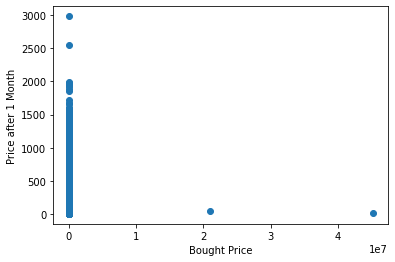

In [99]:
plotProfit(month1, '1 Month')

count    27652.000000
mean        14.222622
std         97.176963
min        -99.999980
25%        -10.225792
50%         -1.044036
75%          9.550760
max        998.214303
dtype: float64


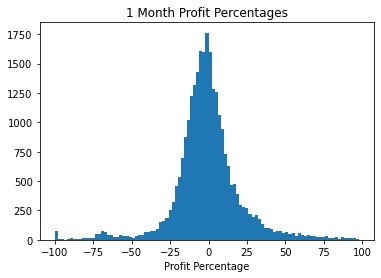

In [97]:
plotProfitHist(month1, '1 Month',name='1monthinsider')

count    26762.000000
mean        16.357453
std        100.253397
min        -99.999980
25%        -12.198195
50%         -0.301432
75%         13.830253
max        999.099082
dtype: float64


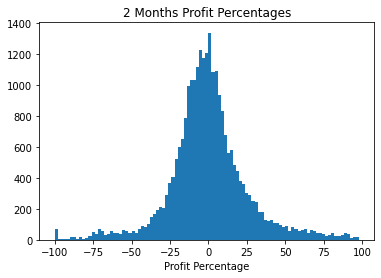

In [96]:
plotProfitHist(month2, '2 Months',name='2monthinsider')

count    25916.000000
mean        19.126799
std        103.701639
min        -99.999980
25%        -13.199692
50%          0.000004
75%         17.814123
max        998.611090
dtype: float64


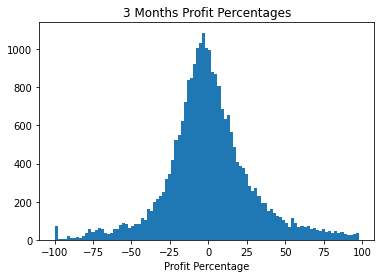

In [95]:
plotProfitHist(month3, '3 Months',name='3monthinsider')

count    23618.000000
mean        25.570535
std        119.440953
min       -101.544029
25%        -17.821810
50%         -0.260635
75%         24.454228
max        999.999990
dtype: float64


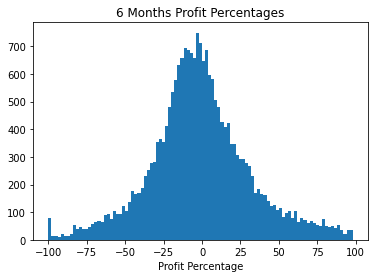

In [94]:
plotProfitHist(month6, '6 Months',name='6monthinsider')

count    19391.000000
mean        35.603933
std        134.568477
min        -99.999978
25%        -21.664666
50%          3.254046
75%         38.130674
max        999.999994
dtype: float64


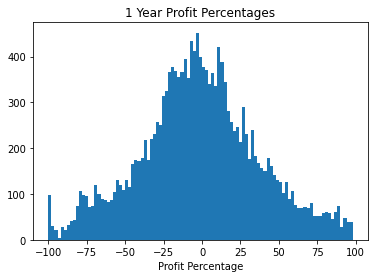

In [93]:
plotProfitHist(year1, '1 Year',name='1yearinsider')

count    10623.000000
mean        45.694551
std        144.128207
min        -99.997333
25%        -25.444296
50%          9.198488
75%         53.679673
max        997.222235
dtype: float64


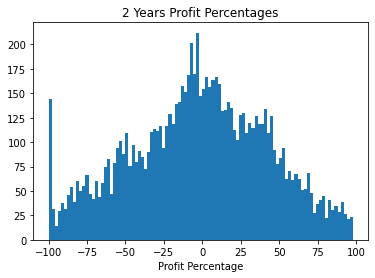

In [92]:
plotProfitHist(year2, '2 Years',name='2yearinsider')

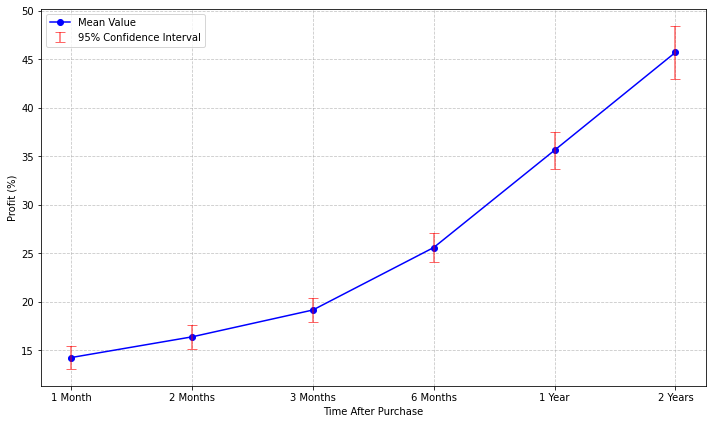

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --- 1. SAMPLE DATA ---
# This simulates your list of lists (e.g., performance across different experiment settings)
# Example: 4 experimental conditions, each with 20 runs (N=20)
data_lists = [
    month1,
    month2,
    month3,
    month6,
    year1,
    year2
]
data_lists = [transform(i) for i in data_lists]
labels = ['1 Month', '2 Months', '3 Months', '6 Months', '1 Year', '2 Years']

# --- 2. CALCULATE MEAN AND 95% CONFIDENCE INTERVALS (CI) ---

means = []
ci_lower = []
ci_upper = []
ci_margins = [] # The distance from the mean (Margin of Error)

# Confidence level (95%)
confidence_level = 0.95

for data in data_lists:
    N = len(data)
    mean_val = np.mean(data)
    
    # Standard Error of the Mean (SEM)
    std_err = stats.sem(data)
    
    # Calculate the t-score for the desired confidence level and degrees of freedom (N-1)
    # The t-score is used for small sample sizes (N < 30) or when std dev is unknown
    t_critical = stats.t.ppf((1 + confidence_level) / 2, N - 1)
    
    # Margin of Error (ME)
    margin_of_error = t_critical * std_err
    
    # Store results
    means.append(mean_val)
    ci_lower.append(mean_val - margin_of_error)
    ci_upper.append(mean_val + margin_of_error)
    ci_margins.append(margin_of_error)

# Convert margins list to a format suitable for plotting (upper/lower errors)
# This is a 2xN array where row 0 is the lower error (mean - lower_bound) 
# and row 1 is the upper error (upper_bound - mean)
yerr = np.array([
    [means[i] - ci_lower[i] for i in range(len(means))],
    [ci_upper[i] - means[i] for i in range(len(means))]
])

# --- 3. PLOT THE RESULTS ---

plt.figure(figsize=(10, 6))

# Plot the means as a line
plt.plot(labels, means, marker='o', linestyle='-', color='blue', label='Mean Value')

# Plot the Confidence Intervals as error bars
# The yerr parameter takes the margin of error array (or the pre-calculated yerr array)
# capsize adds the small horizontal lines at the end of the error bars
plt.errorbar(
    labels, 
    means, 
    yerr=yerr, 
    fmt='none', # Do not plot markers/lines for the error bars themselves
    capsize=5, 
    color='red', 
    alpha=0.6,
    label='95% Confidence Interval'
)


plt.xlabel('Time After Purchase')
plt.ylabel('Profit (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('InsiderTrades_overtime.pdf', format='pdf')
plt.show()